In [1]:
import pandas as pd
import numpy as np
from custom_data_gen import CustomDataGen

In [2]:
df = pd.read_csv("torronto_df.csv").reset_index(drop=True)
df.dtypes

Unnamed: 0             int64
image_file_path       object
fixation_file_path    object
image_width            int64
image_height           int64
center_loc_x           int64
center_loc_y           int64
is_salient             int64
label                 object
dtype: object

In [3]:
df.head()

,Unnamed: 0,image_file_path,fixation_file_path,image_width,image_height,center_loc_x,center_loc_y,is_salient,label
0,0,data\toronto\fixdens\images\1.jpg,data\toronto\fixdens\output\d1.jpg,681,511,355,387,1,salient
1,1,data\toronto\fixdens\images\1.jpg,data\toronto\fixdens\output\d1.jpg,681,511,355,390,1,salient
2,2,data\toronto\fixdens\images\1.jpg,data\toronto\fixdens\output\d1.jpg,681,511,360,374,1,salient
3,3,data\toronto\fixdens\images\1.jpg,data\toronto\fixdens\output\d1.jpg,681,511,351,376,1,salient
4,4,data\toronto\fixdens\images\1.jpg,data\toronto\fixdens\output\d1.jpg,681,511,367,382,1,salient


In [4]:
import seaborn as sns

<AxesSubplot:xlabel='center_loc_x', ylabel='Count'>

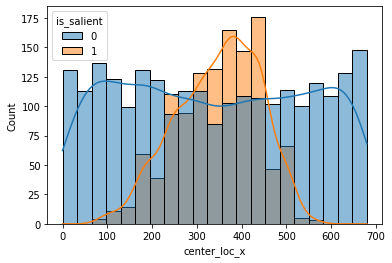

In [5]:
sns.histplot(data=df, x='center_loc_x', hue='is_salient', kde=True)

<AxesSubplot:xlabel='center_loc_y', ylabel='Count'>

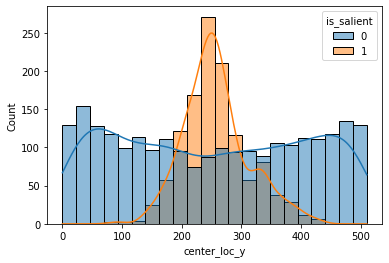

In [6]:
sns.histplot(data=df, x='center_loc_y', hue='is_salient', kde=True)

In [7]:
train = df.sample(frac=0.7, random_state=200)  #random state is a seed value
test = df.drop(train.index)


In [8]:
batch_size = 8
target_size = (400, 400)


In [9]:
traingen = CustomDataGen(train,
                         X_col={
                             'image_file_path': 'image_file_path',
                             'center_loc_x': 'center_loc_x',
                             'center_loc_y': 'center_loc_y',
                         },
                         y_col={'is_salient': 'is_salient'},
                         batch_size=batch_size,
                         input_size=target_size)
valgen = CustomDataGen(test,
                       X_col={
                           'image_file_path': 'image_file_path',
                           'center_loc_x': 'center_loc_x',
                           'center_loc_y': 'center_loc_y',
                       },
                       y_col={'is_salient': 'is_salient'},
                       batch_size=batch_size,
                       input_size=target_size)


In [10]:
x, y = traingen[0];

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Add
from tensorflow.keras.models import Model
import tensorflow as tf

In [12]:
def initialize_base_network(stream_name, patch_size=(42, 42, 3)):
    input = Input(shape=(patch_size), name='patch_input')
    x = Conv2D(96, 7, activation='relu', name='conv_1')(input)
    x = MaxPool2D((2, 2))(x)
    x = Conv2D(160, 3, activation='relu', name='conv_2')(x)
    x = MaxPool2D((2, 2))(x)
    x = Conv2D(288, 3, activation='relu', name='conv_3')(x)
    x = MaxPool2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='dense_stream')(x)
    return Model(inputs=input, outputs=x, name=stream_name)

In [13]:
input_image_1 = Input(shape=(
    42,
    42,
    3,
), name='input_img_1')
stream_s1 = initialize_base_network(stream_name='stream_1')
vec_output_a = stream_s1(input_image_1)

input_image_2 = Input(shape=(
    42,
    42,
    3,
), name='input_img_2')
stream_s2 = initialize_base_network(stream_name='stream_2')
vec_output_b = stream_s2(input_image_2)

input_image_3 = Input(shape=(
    42,
    42,
    3,
), name='input_img_3')
stream_s3 = initialize_base_network(stream_name='stream_3')
vec_output_c = stream_s3(input_image_3)

In [14]:
added = Add(name='add_streams')([vec_output_a, vec_output_b, vec_output_c])
x = Dense(512, activation='relu', name='dense_all')(added)
output = Dense(1, activation='sigmoid', name='output')(x)

In [15]:
model = Model([input_image_1, input_image_2, input_image_3],
              output,
              name='mr-cnn')


In [16]:
model.summary()

Model: "mr-cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img_1 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 input_img_2 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 input_img_3 (InputLayer)       [(None, 42, 42, 3)]  0           []                               
                                                                                                  
 stream_1 (Functional)          (None, 512)          1895232     ['input_img_1[0][0]']            
                                                                                             

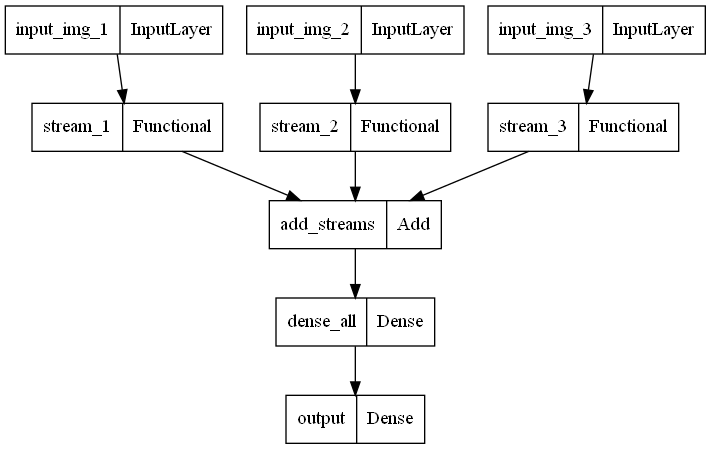

In [17]:
tf.keras.utils.plot_model(model)

In [18]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam')
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [19]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
cce = tf.keras.losses.CategoricalCrossentropy()

In [20]:
model.compile(optimizer=adam, loss=bce, metrics=['accuracy'])


In [21]:
model.fit(traingen, validation_data=valgen, epochs=5)

Epoch 1/5
315/315 [==============================] - 94s 287ms/step - loss: 0.5338 - accuracy: 0.6532 - val_loss: 0.5282 - val_accuracy: 0.6074
Epoch 2/5
315/315 [==============================] - 92s 292ms/step - loss: 0.5186 - accuracy: 0.6631 - val_loss: 0.5203 - val_accuracy: 0.6815
Epoch 3/5
315/315 [==============================] - 96s 305ms/step - loss: 0.5119 - accuracy: 0.6663 - val_loss: 0.5325 - val_accuracy: 0.6870
Epoch 4/5
315/315 [==============================] - 93s 294ms/step - loss: 0.5074 - accuracy: 0.6690 - val_loss: 0.5158 - val_accuracy: 0.7009
Epoch 5/5
315/315 [==============================] - 93s 294ms/step - loss: 0.5119 - accuracy: 0.6782 - val_loss: 0.5264 - val_accuracy: 0.6926


In [22]:
x, y = traingen[14]
model.predict_step((x, y))


<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.2896956 ],
       [0.30537057],
       [0.17202792],
       [0.30069697],
       [0.5877181 ],
       [0.03557533],
       [0.43200397],
       [0.5473932 ]], dtype=float32)>